In [1]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


In [2]:
mask = ((ppmi_ad.obs['Age_Group'] == '50-70') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [3]:
ppmi_ad = ppmi_ad[mask]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    chi2
)
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

In [5]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_highvar)

In [8]:
n_top_genes = 20000

### Anova F-Value

In [6]:
var_selector = VarianceThreshold(threshold=0.1)
X_highvar = var_selector.fit_transform(X)
selected_genes = X.columns[var_selector.get_support()]
print(f"After variance threshold: {len(selected_genes)} genes remaining")

After variance threshold: 56059 genes remaining


In [9]:
anova_scores, _ = f_classif(X_scaled, y)
top_indices_anovaf = np.argsort(anova_scores)[-n_top_genes:][::-1]
anova_selected_genes = selected_genes[top_indices_anovaf]
anova_selected_genes

Index(['ENSG00000257878.1', 'ENSG00000226067.6', 'ENSG00000257715.1',
       'ENSG00000285215.2', 'ENSG00000259379.1', 'ENSG00000163235.15',
       'ENSG00000181016.9', 'ENSG00000252577.1', 'ENSG00000277763.1',
       'ENSG00000145491.11',
       ...
       'ENSG00000163626.16', 'ENSG00000243368.2', 'ENSG00000251336.1',
       'ENSG00000138316.10', 'ENSG00000252022.1', 'ENSG00000236193.3',
       'ENSG00000270855.1', 'ENSG00000236844.1', 'ENSG00000167515.10',
       'ENSG00000241722.2'],
      dtype='object', length=20000)

### Chi-Squared

In [10]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_processed = discretizer.fit_transform(X_scaled)
chi2_scores, _ = chi2(X_processed, y)
top_indices_chi2 = np.argsort(chi2_scores)[-n_top_genes:][::-1]
chi2_selected_genes = selected_genes[top_indices_chi2]
chi2_selected_genes

Index(['ENSG00000276941.1', 'ENSG00000274197.1', 'ENSG00000267224.1',
       'ENSG00000276577.1', 'ENSG00000227574.2', 'ENSG00000206686.1',
       'ENSG00000234001.1', 'ENSG00000251954.1', 'ENSG00000241838.3',
       'ENSG00000251705.1',
       ...
       'ENSG00000261273.1', 'ENSG00000226017.2', 'ENSG00000227179.6',
       'ENSG00000241899.1', 'ENSG00000226122.1', 'ENSG00000108688.11',
       'ENSG00000261325.1', 'ENSG00000270531.1', 'ENSG00000164399.4',
       'ENSG00000277147.5'],
      dtype='object', length=20000)

### Mutual Information

In [11]:
mutual_info_scores = mutual_info_classif(X_scaled, y)
top_indices_mutual_info = np.argsort(mutual_info_scores)[-n_top_genes:][::-1]
mutual_info_selected_genes = selected_genes[top_indices_mutual_info]
mutual_info_selected_genes

Index(['ENSG00000224391.1', 'ENSG00000253581.1', 'ENSG00000270308.1',
       'ENSG00000255690.2', 'ENSG00000105355.8', 'ENSG00000229557.1',
       'ENSG00000215270.3', 'ENSG00000189241.6', 'ENSG00000137872.16',
       'ENSG00000259698.1',
       ...
       'ENSG00000260286.3', 'ENSG00000273919.1', 'ENSG00000269177.1',
       'ENSG00000253109.1', 'ENSG00000124215.16', 'ENSG00000224594.2',
       'ENSG00000279001.1', 'ENSG00000248160.1', 'ENSG00000183145.8',
       'ENSG00000163069.12'],
      dtype='object', length=20000)

### Fisher's Score

In [12]:
from skfeature.function.similarity_based import fisher_score
fisher_score = fisher_score.fisher_score(X_scaled, np.asarray(y))
top_indices_fisher = np.argsort(fisher_score)[-n_top_genes:][::-1]
fisher_selected_genes = selected_genes[top_indices_fisher]
fisher_selected_genes

Index(['ENSG00000244267.1', 'ENSG00000182798.10', 'ENSG00000259042.2',
       'ENSG00000253539.1', 'ENSG00000244436.2', 'ENSG00000249453.1',
       'ENSG00000249934.2', 'ENSG00000250862.1', 'ENSG00000284546.1',
       'ENSG00000148572.15',
       ...
       'ENSG00000182518.13', 'ENSG00000133937.4', 'ENSG00000128203.6',
       'ENSG00000214535.3', 'ENSG00000284655.1', 'ENSG00000207044.1',
       'ENSG00000276755.1', 'ENSG00000279511.1', 'ENSG00000262786.1',
       'ENSG00000250962.1'],
      dtype='object', length=20000)

### Overlapping Genes

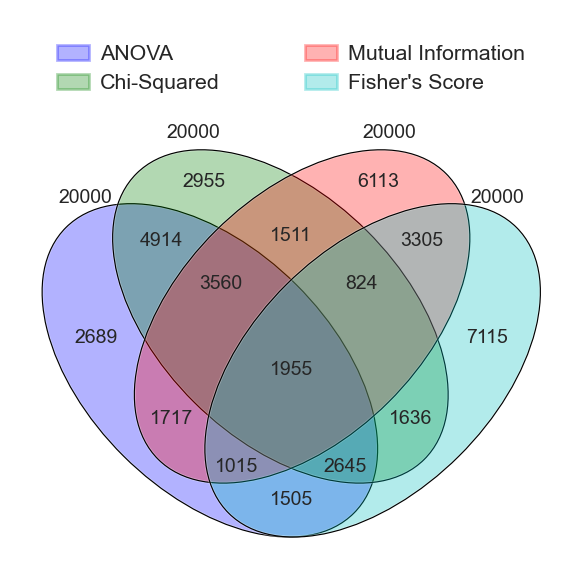

In [13]:
from venny4py.venny4py import *

sets = {
    'ANOVA': set(anova_selected_genes),
    'Chi-Squared': set(chi2_selected_genes),
    'Mutual Information': set(mutual_info_selected_genes),
    'Fisher\'s Score': set(fisher_selected_genes)
}
venny4py(sets=sets)


In [14]:
common_genes = set(anova_selected_genes) & set(chi2_selected_genes) & set(mutual_info_selected_genes) & set(fisher_selected_genes)
print(f"Number of common genes across methods: {len(common_genes)}")
print("Common genes:")
print(common_genes)

Number of common genes across methods: 1955
Common genes:
{'ENSG00000141979.4', 'ENSG00000226939.1', 'ENSG00000250622.1', 'ENSG00000159110.19', 'ENSG00000248717.1', 'ENSG00000233887.1', 'ENSG00000285977.1', 'ENSG00000154589.6', 'ENSG00000159658.10', 'ENSG00000124207.16', 'ENSG00000276083.1', 'ENSG00000257860.5', 'ENSG00000272337.1', 'ENSG00000271205.1', 'ENSG00000137509.10', 'ENSG00000178761.14', 'ENSG00000274799.1', 'ENSG00000257858.1', 'ENSG00000244429.1', 'ENSG00000207185.1', 'ENSG00000253154.2', 'ENSG00000263815.2', 'ENSG00000169403.11', 'ENSG00000148356.13', 'ENSG00000258474.1', 'ENSG00000259255.1', 'ENSG00000237179.5', 'ENSG00000280571.2', 'ENSG00000265061.1', 'ENSG00000237923.1', 'ENSG00000265347.1', 'ENSG00000161807.3', 'ENSG00000238961.1', 'ENSG00000252138.1', 'ENSG00000281183.1', 'ENSG00000251573.2', 'ENSG00000272559.1', 'ENSG00000241015.2', 'ENSG00000180884.9', 'ENSG00000212308.1', 'ENSG00000166501.13', 'ENSG00000201065.1', 'ENSG00000281269.1', 'ENSG00000257648.1', 'ENSG0000

In [15]:
method_collection = {
    'ANOVA': {
        'score': anova_scores,
        'genes': anova_selected_genes
    },
    'Chi-Squared': {
        'score': chi2_scores,
        'genes': chi2_selected_genes
    },
    'Mutual Information': {
        'score': mutual_info_scores,
        'genes': mutual_info_selected_genes
    },
    'Fisher\'s Score': {
        'score': fisher_score,
        'genes': fisher_selected_genes
    }
}

In [16]:
all_selected_genes = set()
for method in method_collection.values():
    all_selected_genes.update(method["genes"])

In [17]:
comparison = pd.DataFrame(index=list(all_selected_genes))

In [18]:
for method_name, results in method_collection.items():
    comparison[method_name] = 0
    comparison.loc[results['genes'], method_name] = 1
comparison['Times_Selected'] = comparison.sum(axis=1)

In [19]:
n_methods = len(method_collection)
consensus_genes = comparison[comparison['Times_Selected'] == n_methods]
print(f"Genes selected by ALL methods: {len(consensus_genes)}")

Genes selected by ALL methods: 1955


In [20]:
consensus_genes

,ANOVA,Chi-Squared,Mutual Information,Fisher's Score,Times_Selected
ENSG00000233887.1,1,1,1,1,4
ENSG00000276083.1,1,1,1,1,4
ENSG00000274799.1,1,1,1,1,4
ENSG00000280571.2,1,1,1,1,4
ENSG00000087074.7,1,1,1,1,4
...,...,...,...,...,...
ENSG00000151233.10,1,1,1,1,4
ENSG00000251470.1,1,1,1,1,4
ENSG00000198663.16,1,1,1,1,4
ENSG00000275676.1,1,1,1,1,4


In [21]:
symbol_ensembl_mapping = ppmi_ad.varm['symbol_ensembl_mapping'].loc[consensus_genes.index,:]['gene_symbol']

In [22]:
importance_df = pd.DataFrame(index=consensus_genes.index)

### Importance Scores

In [23]:
import math

def plot_feature_importances(method_collection, consensus_genes, symbol_ensembl_mapping):
    plt.figure(figsize=(15, 16))
    idx = 1
    for method_name, results in method_collection.items():
        df = pd.DataFrame({
            'Gene': selected_genes,
            'Score': results['score']
        })
        df_consensus = df[df['Gene'].isin(consensus_genes.index)]
        df_consensus = df_consensus.merge(
            symbol_ensembl_mapping.rename('gene_symbol'),
            left_on='Gene',
            right_index=True,
            how='left'
        )
        df_consensus = df_consensus.sort_values('Score', ascending=False)
        sns.set_style("whitegrid")
        subplot_row_count = math.ceil(len(method_collection) / 2)
        plt.subplot(subplot_row_count, 2, idx)
        plt.title(f' (Males 50-70) {method_name}', fontsize=14)
        ax = sns.barplot(
                data=df_consensus,
                x='Score',
                y='gene_symbol',
                palette="Blues_d",
                orient='h',
                dodge=False
            )
        idx += 1
        for i, score in enumerate(df_consensus['Score']):
            score_fmt = f'{score: .4f}' if method_name == 'Mutual Information' else f'{score: .1f}'
            ax.text(score, i, score_fmt, va='center', fontsize=6)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
    plt.tight_layout
    plt.show()

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_8657/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_8657/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_8657/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_8657/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is d

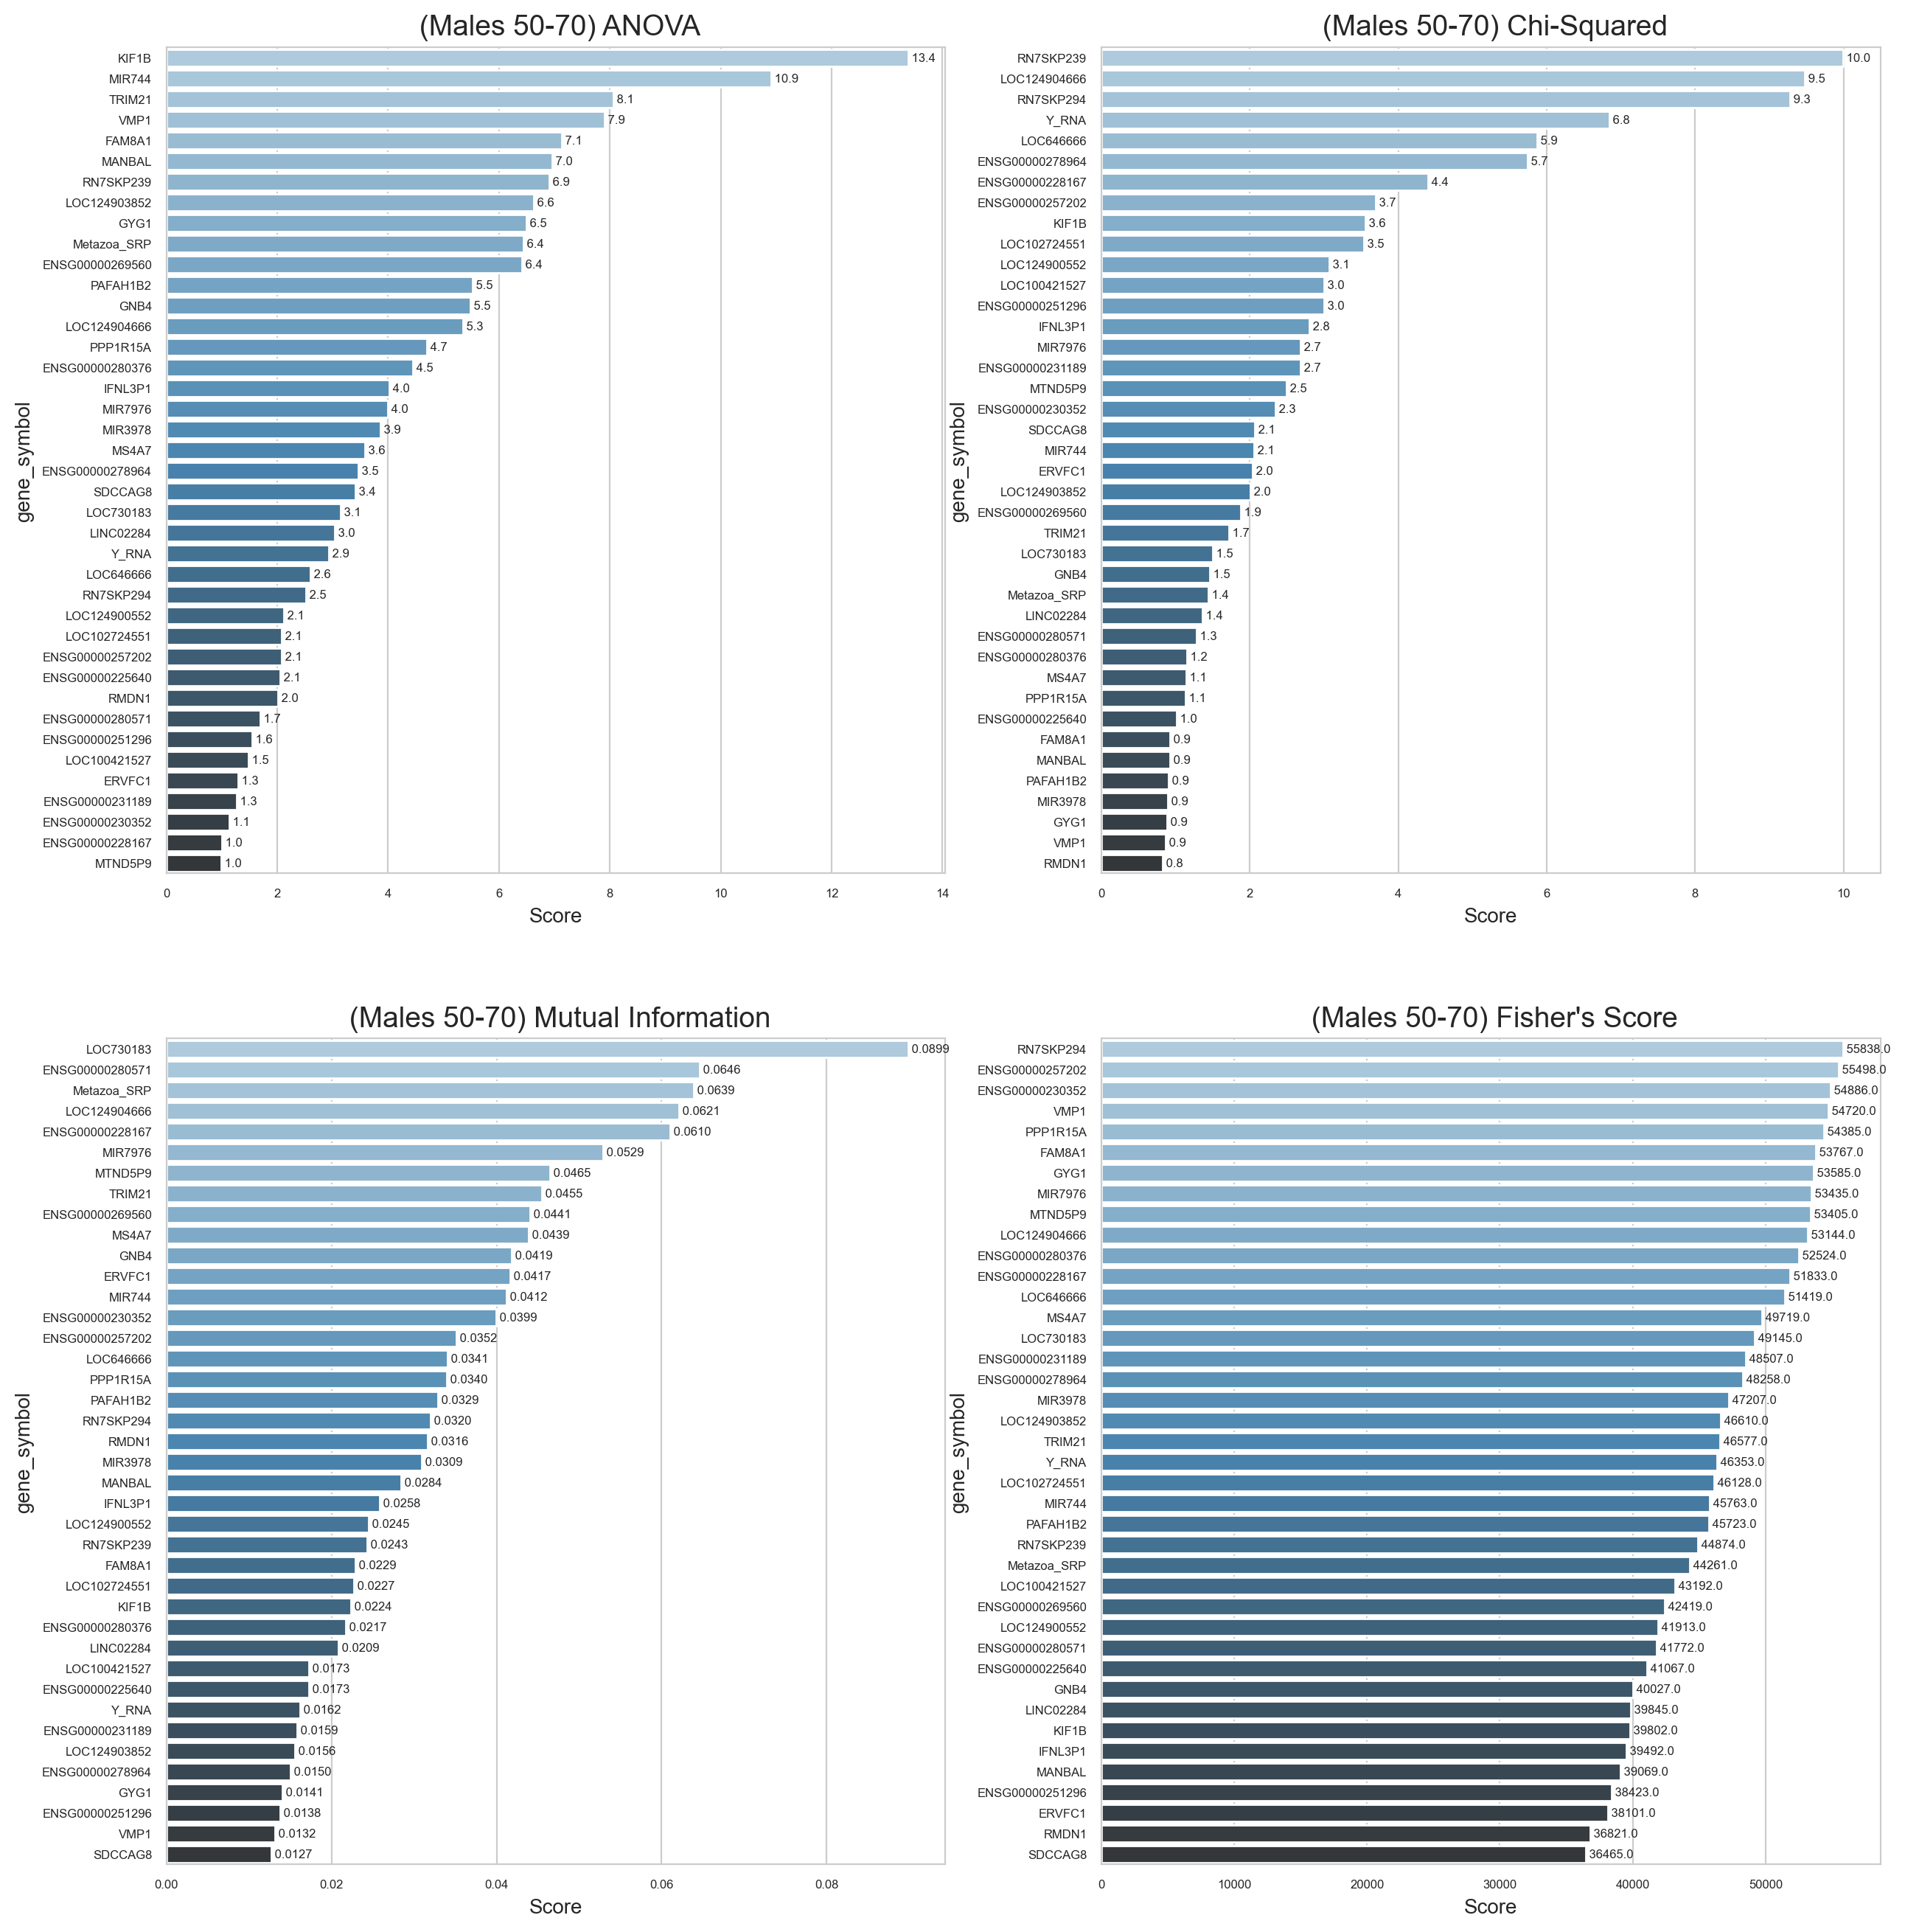

In [25]:
import seaborn as sns
plot_feature_importances(method_collection, consensus_genes.head(40), symbol_ensembl_mapping)

In [26]:
consensus_gene_symbols = symbol_ensembl_mapping[consensus_genes.index].to_frame()

### Enrichment of Consensus Genes

In [27]:
import gseapy as gp

In [28]:
enr = gp.enrichr(gene_list=consensus_gene_symbols['gene_symbol'].to_list(),
                 gene_sets=['MSigDB_Hallmark_2020',
                            'KEGG_2021_Human',
                            'WikiPathways_2024_Human',
                            'Human_Phenotype_Ontology',
                            'GO_Biological_Process_2023',
                            'GO_Molecular_Function_2023',
                            'GO_Cellular_Component_2023',
                            'SynGO_2024',
                            'OMIM_Disease'],
                 organism='human')

In [29]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Protein Secretion,9/96,0.581397,0.999996,0,0,0.973453,0.527924,COPB1;ATP6V1H;RAB9A;KIF1B;SEC22B;GLA;COPE;VAMP...
1,MSigDB_Hallmark_2020,Unfolded Protein Response,10/113,0.654484,0.999996,0,0,0.913261,0.387139,CNOT6;HSPA5;XPOT;SLC30A5;CNOT2;NABP1;WIPI1;ALD...
2,MSigDB_Hallmark_2020,Reactive Oxygen Species Pathway,4/49,0.705180,0.999996,0,0,0.836214,0.292092,MSRA;GPX3;MBP;OXSR1
3,MSigDB_Hallmark_2020,Interferon Gamma Response,16/200,0.813031,0.999996,0,0,0.816844,0.169075,CD86;IFNAR2;NCOA3;MVP;SECTM1;NOD1;TOR1B;HIF1A;...
4,MSigDB_Hallmark_2020,Complement,16/200,0.813031,0.999996,0,0,0.816844,0.169075,CDA;DOCK4;GCA;HSPA5;ANXA5;PRCP;VCPIP1;GNGT2;XP...
...,...,...,...,...,...,...,...,...,...,...
5742,OMIM_Disease,epilepsy,2/58,0.979636,0.996515,0,0,0.335424,0.006901,SLC25A22;POLG
5743,OMIM_Disease,cardiomyopathy,1/42,0.985674,0.996515,0,0,0.229141,0.003307,DSP
5744,OMIM_Disease,retinitis pigmentosa,1/51,0.994238,0.996515,0,0,0.187802,0.001085,CA4
5745,OMIM_Disease,mental retardation,4/114,0.996319,0.996515,0,0,0.340855,0.001257,DIP2B;BRWD3;ARHGEF6;CUL4B


In [30]:
enr_res_pivot = enr.results.pivot(index='Term', columns='Genes', values='P-value')
enr_res_pivot = enr_res_pivot.fillna(1.0)

Text(0.5, 1.0, 'GSEA Results of Consensus Genes for Males Aged 50-70')

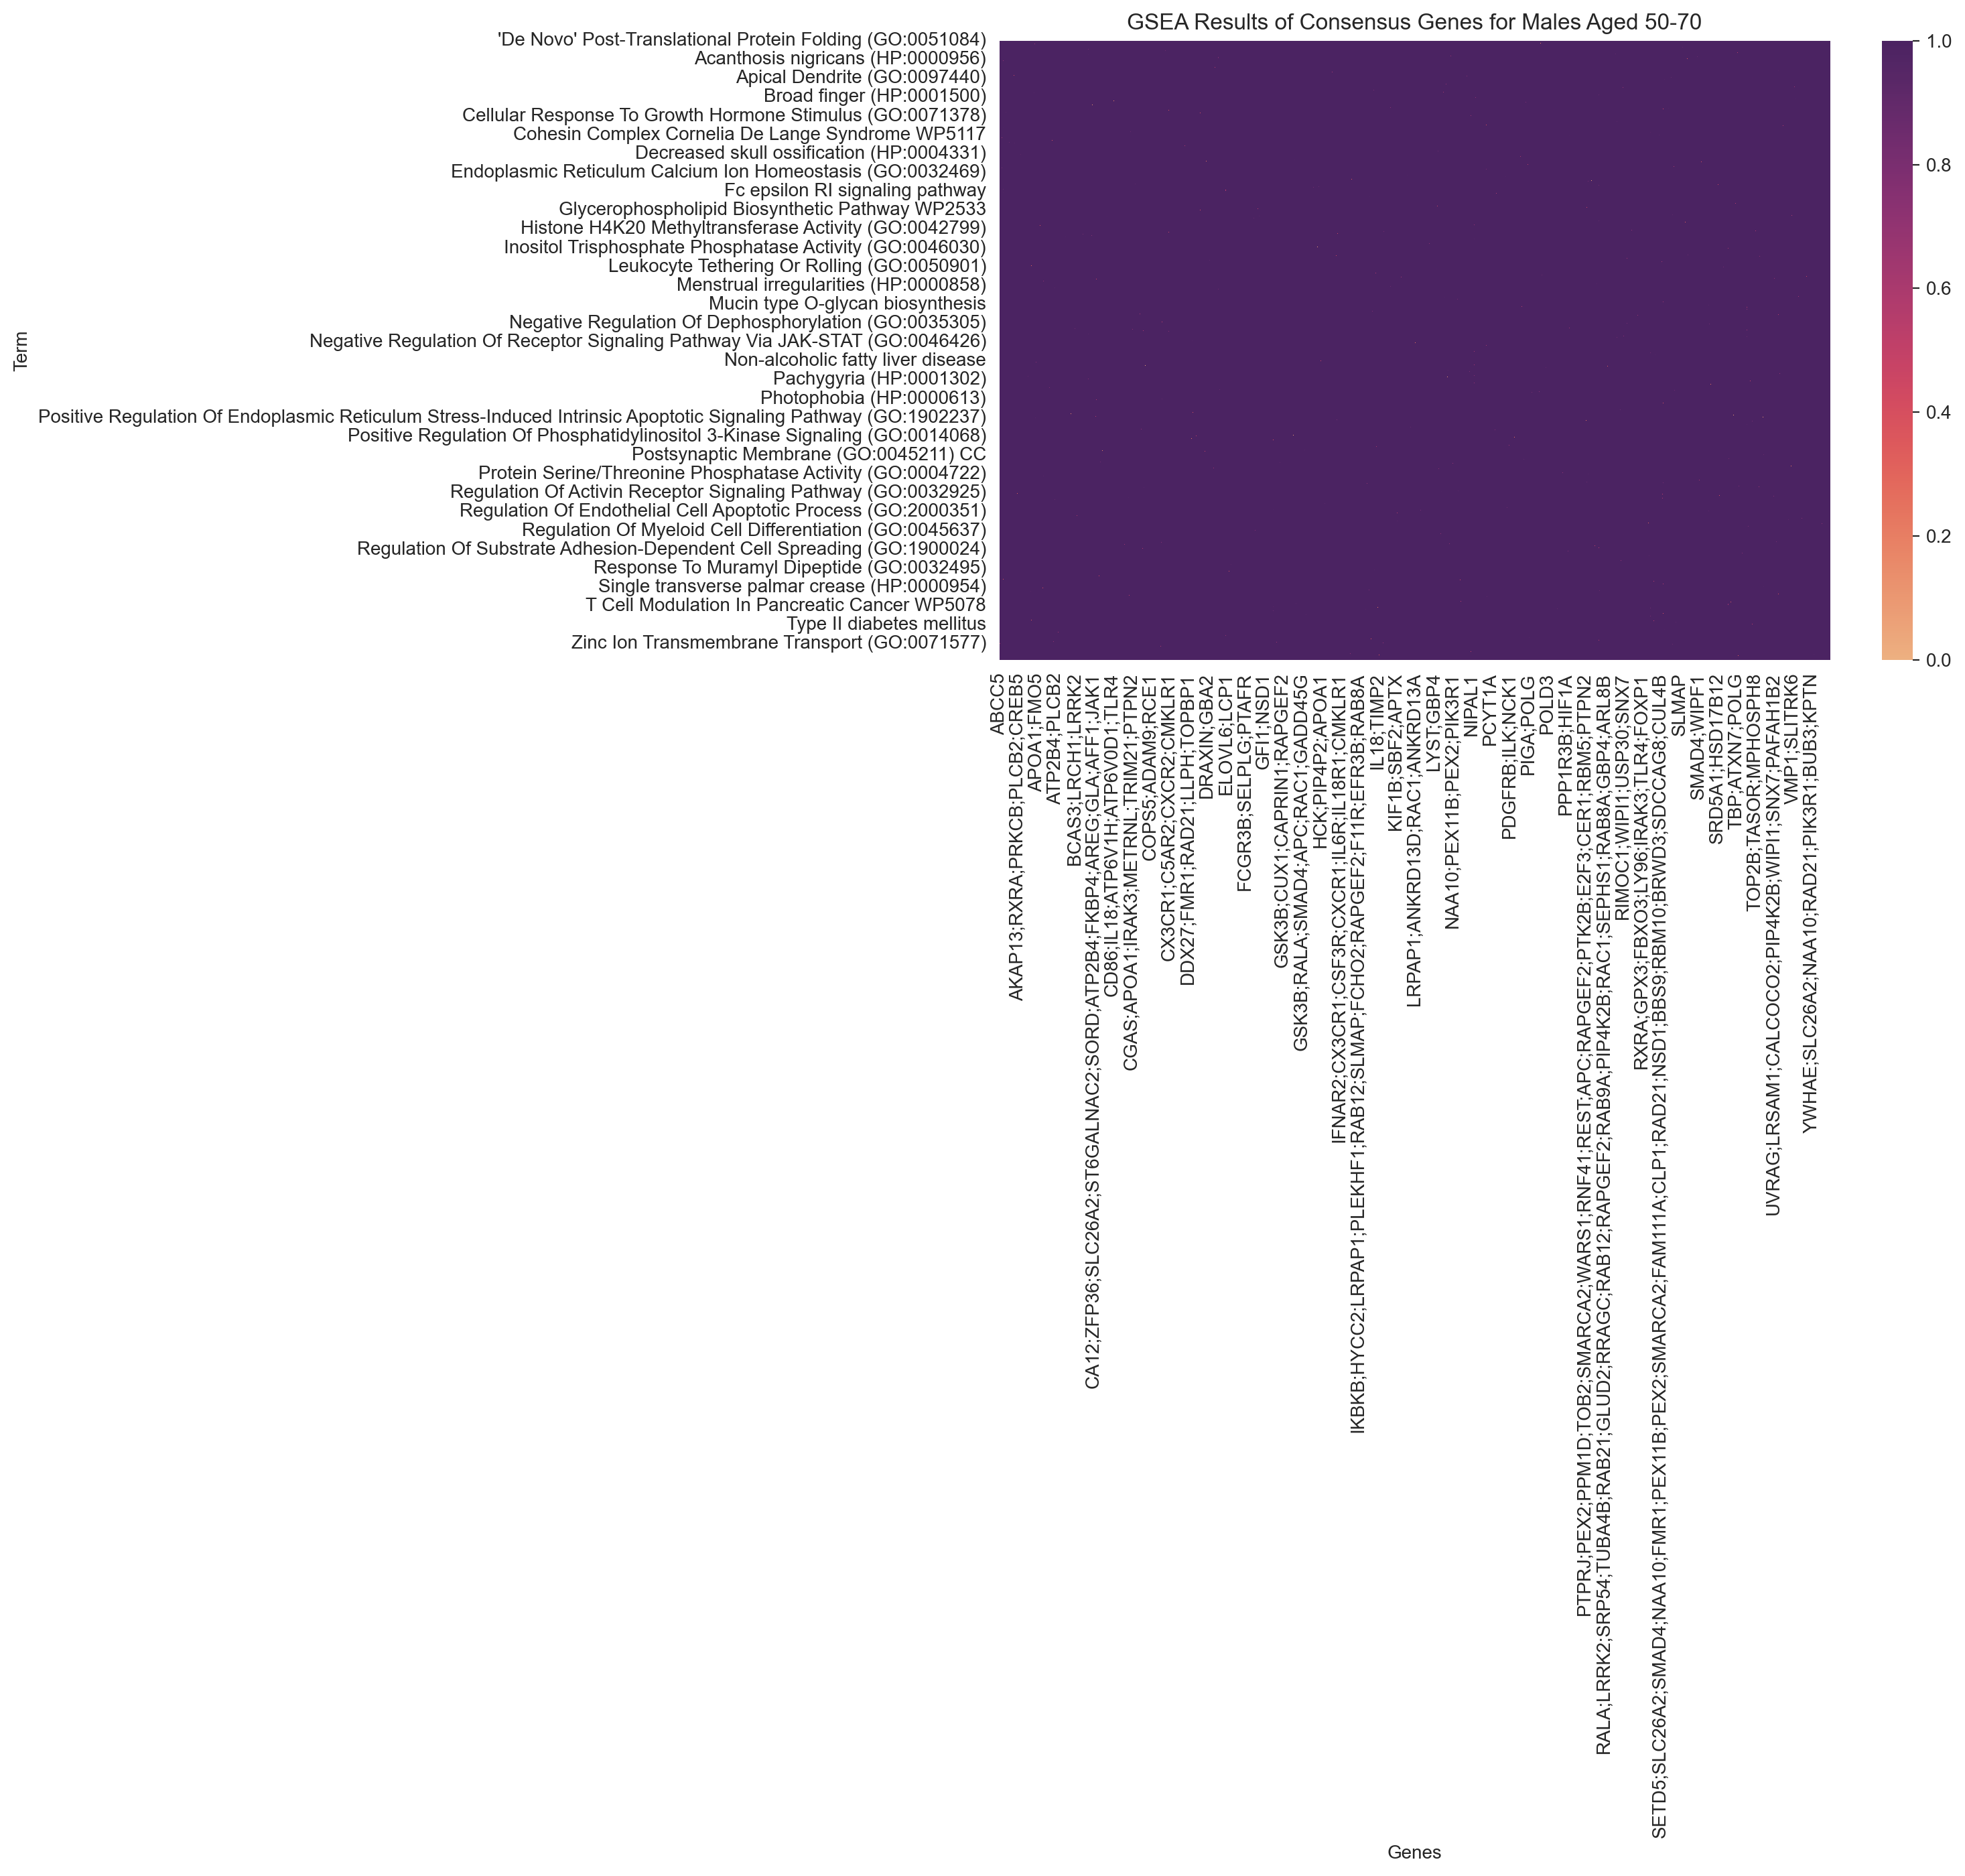

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    enr_res_pivot,
    cmap='flare',
    fmt='.3f',
    vmin=0, vmax=1
)
plt.title("GSEA Results of Consensus Genes for Males Aged 50-70")

In [32]:
symbol_ensembl_mapping.to_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_50-70.csv")